In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pylab as pl 
libPath = 'project1/scripts'
import sys
if not libPath in sys.path: sys.path.append(libPath)
from implementations import *

# 1. Missing data analysis

In this analysis, we want to determine a method for replacing the missing data (-999) elements in the train dataset. Two methods are considered:
1. Missing data is replaced by the mean or median of the feature;
2. Missing data is replaced by predicted values calculated using other (meaningful features).

First let's calculate the cross-correlation matrix for all 30 features to determine which ones influence each other and possible prediction patterns. Features which are considered to not be influenced by others should be replaced by their mean.

## 1.2. Missing data profile

Some preliminary analysis on where we can find missing data.

### 1.2.1. Load train data

In [2]:
df_tr = pd.read_csv("train.csv")
dict_tr = dict(s=1, b=-1)

# Apply the dictionary to the dataset 
df_tr = df_tr.replace(dict_tr, regex=True)

column_labels = df_tr.columns.values
data_tr = df_tr.values
input_data_tr= data_tr[:,2:]
y_tr = data_tr[:,1]
df_tr.dtypes


Id                               int64
Prediction                       int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt       

In [3]:
df_tr.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,1,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,-1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,-1,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,-1,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,-1,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [4]:
print('Number of missing data in each feature: \n', np.count_nonzero(input_data_tr == -999,0) )

Number of missing data in each feature: 
 [ 38114      0      0      0 177457 177457 177457      0      0      0
      0      0 177457      0      0      0      0      0      0      0
      0      0      0  99913  99913  99913 177457 177457 177457      0]


In [5]:
x = np.unique(np.where(input_data_tr == -999.0)[1])

print('Features with missing data: ', x)

Features with missing data:  [ 0  4  5  6 12 23 24 25 26 27 28]


## 1.3. Import clean data

To calculate the cross-correlation matrix we will use the data previously cleaned.

In [6]:
df = pd.read_csv('clean_train_data.csv')
data = df.values
input_data = data[:,2:]
y = data[:,1]

N_f = input_data.shape[1]
N_s = input_data.shape[0]
print("Number of features:", N_f)
print("Number of samples:", N_s)


Number of features: 30
Number of samples: 68114


## 1.4. Correlation matrix

Next let's determine which features can be associated to the others.

In [7]:
# Calculate correlation
R = np.corrcoef(input_data.T)

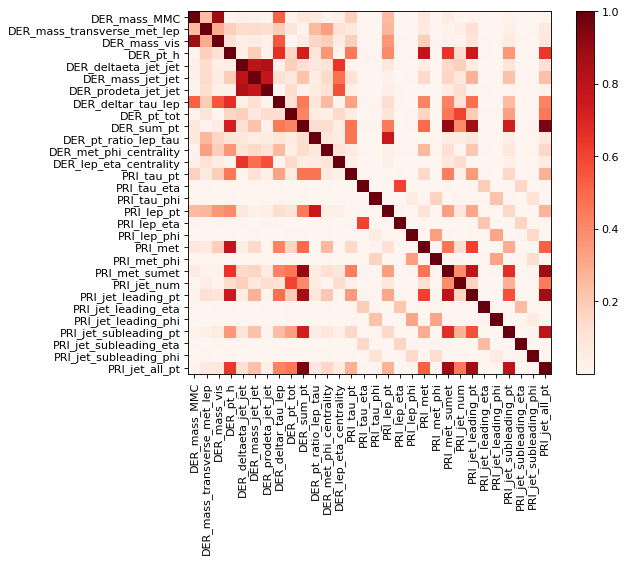

In [8]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(np.abs(R), cmap='Reds')
plt.colorbar()
plt.xticks(np.arange(N_f), column_labels[2:], rotation=90);
plt.yticks(np.arange(N_f), column_labels[2:]);

We would like to determine for each feature with missing data, if there is another feature highly correlated to it.

In [9]:
x_=-np.ones([30, 30])
x_c=-np.ones([30, 30])

for i in x:
    x_[i,:]=np.argsort(R[i])[::-1]
    x_c[i,:]=np.sort(R[i])[::-1]

x_ = x_[:,1]
x_ = x_[x_ > -1]
x_c = x_c[:,1]
x_c = x_c[x_c > -1]

Features which the most correlated with the features indicated in vector x.

In [10]:
x_

array([ 2.,  5.,  4.,  8.,  4., 29., 17., 21., 29., 17.,  7.])

These are the features with missing data that have strong correlation with other features.

In [11]:
print(x[x_c>0.5], 'are correlated with',x_[x_c>0.5])

[ 0  4  5 12 23 26] are correlated with [ 2.  5.  4.  4. 29. 29.]


These are the features from which a prediction model can be derived (regression from feature 2 to determine 0, from feature 29 to determine 23 and 26). For these we consider approach 2.

In [12]:
cond=np.bitwise_and(x_c>0.5 , ~np.in1d(x_,x))
feat_appr2 = x[cond]
print(x[cond], 'are correlated with',x_[cond])

[ 0 23 26] are correlated with [ 2. 29. 29.]


These are the features with missing data (from vector x) that are very little correlated with other features OR that are strongly correlated to other but that also have missing features. For these, we will consider approach 1.

In [13]:
feat_appr1=x[~cond]
feat_appr1

array([ 4,  5,  6, 12, 24, 25, 27, 28])

## 1.5. Determine model for missing data 

### 1.5.1. Approach 1: Mean

In this approach missing data in variables [4, 5, 6, 12, 24, 25, 27, 28] are replaced by their mean value.

In [14]:
df_tr_na = df_tr.dropna()
input_data_na = df_tr_na.iloc[:,2:].values

In [15]:
mean = np.mean(input_data_na, 0)
mean

array([-4.90230794e+01,  4.92398193e+01,  8.11819816e+01,  5.78959617e+01,
       -7.08420675e+02, -6.01237051e+02, -7.09356603e+02,  2.37309984e+00,
        1.89173324e+01,  1.58432217e+02,  1.43760943e+00, -1.28304708e-01,
       -7.08985189e+02,  3.87074191e+01, -1.09730480e-02, -8.17107200e-03,
        4.66602072e+01, -1.95074680e-02,  4.35429640e-02,  4.17172345e+01,
       -1.01191920e-02,  2.09797178e+02,  9.79176000e-01, -3.48329567e+02,
       -3.99254314e+02, -3.99259788e+02, -6.92381204e+02, -7.09121609e+02,
       -7.09118631e+02,  7.30645914e+01])

In [16]:
for i in feat_appr1:
    np.place(input_data_tr[:,i], input_data_tr[:,i] == -999, mean[i].astype(float))


In [17]:
x = np.unique(np.where(input_data_tr == -999.0)[1])

print('Features with missing data: ', x)

Features with missing data:  [ 0 23 26]


### 1.5.2. Approach 2: Linear regression

In this approach missing data in variables [0 23 26] are replaced by some linear regression rule.

In [18]:
y_2 = input_data[feat_appr2]
input_data_2 = input_data[x_[cond].astype(int)]
input_data_2.shape

(3, 30)

Linear regression with LS:

In [19]:
w_vec = np.zeros([2, y_2.shape[0]])
loss_te_vec = np.zeros( y_2.shape[0])
loss_tr_vec = np.zeros( y_2.shape[0])


for i in np.arange(y_2.shape[0]):
    x_tr, y_tr, x_te, y_te = split_data(input_data_2[i] ,y_2[i], 0.8)
    tx_tr =build_poly(x_tr, 1) # polynomial of degree 1
    tx_te =build_poly(x_te, 1) # polynomial of degree 1
    wls, lossls = least_squares(y_tr, tx_tr)
    w_vec[:,i]=wls
    loss_tr_vec[i] = lossls
    loss_te_vec[i] = compute_mse(y_te,tx_te,wls)


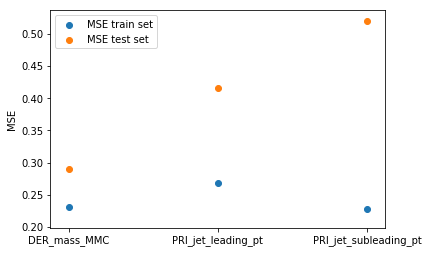

In [20]:
h1=plt.scatter(np.arange(3),loss_tr_vec)
h2=plt.scatter(np.arange(3),loss_te_vec)
plt.xticks(np.arange(3), column_labels[feat_appr2+2], rotation=0)
plt.ylabel('MSE')
plt.legend((h1,h2),('MSE train set','MSE test set'));

In [21]:
x_pred = input_data_tr[:,feat_appr2].astype(float)
y_pre = np.zeros([input_data_tr.shape[0],3])
for i in np.arange(3):
    tx_pred = build_poly(x_pred[:,i], 1)
    y_pre[:,i] = tx_pred @ w_vec[:,i]
for ii,i in enumerate(feat_appr2):
    np.place(input_data_tr[:,i], input_data_tr[:,i] == -999, y_pre[ii].astype(float))


In [22]:
x = np.unique(np.where(input_data_tr == -999.0)[1])

print('Features with missing data: ', x)

Features with missing data:  []


Checking the correlation matrix for the new data:

In [23]:
R_tr = np.corrcoef((input_data_tr.T).astype(float))

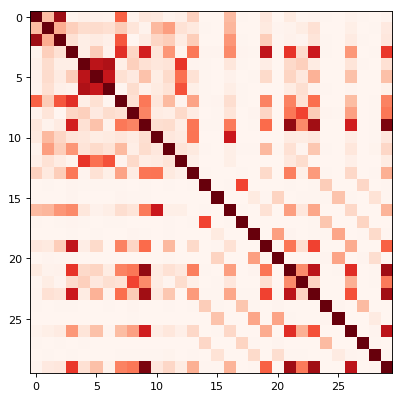

In [24]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(np.abs(R), cmap='Reds')

Check more statistical data:

In [25]:
data_full = np.hstack((data_tr[:,0:1],data_tr[:,1:2],input_data_tr))
data_full.dtype

dtype('float64')

In [26]:
#np.savetxt("full_train_data.csv", data_full, delimiter=",", header=','.join(column_labels))


In [27]:
#fulldata =pd.read_csv("full_train_data.csv")
#fulldata.head()

,# Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000.0,1.0,138.470000,51.655,97.827,27.980,0.910000,124.711000,2.666000,3.064,...,-0.277,258.733,2.0,67.435000,2.150000,0.444000,46.062000,1.240000,-2.475000,113.497
1,100001.0,-1.0,160.937000,68.768,103.235,48.146,-708.420675,-601.237051,-709.356603,3.473,...,-1.916,164.546,1.0,46.226000,0.725000,1.158000,-640.644836,-709.121609,-709.118631,46.226
2,100002.0,-1.0,88.689354,162.172,125.953,35.635,-708.420675,-601.237051,-709.356603,3.148,...,-2.186,260.414,1.0,44.251000,2.053000,-2.028000,-9.060645,-709.121609,-709.118631,44.251
3,100003.0,-1.0,143.905000,81.417,80.943,0.414,-708.420675,-601.237051,-709.356603,3.310,...,0.060,86.062,0.0,103.094966,-399.254314,-399.259788,766.426608,-709.121609,-709.118631,0.000
4,100004.0,-1.0,175.864000,16.915,134.805,16.405,-708.420675,-601.237051,-709.356603,3.891,...,-0.871,53.131,0.0,-9.466286,-399.254314,-399.259788,-640.644836,-709.121609,-709.118631,0.000
